# 개, 고양이 분류(partial) - CNN v1
- 부분 데이터:

    훈련_ 개: 1000, 고양이: 1000; 테스트_ 개: 500, 고양이: 500
- 이미지 센터링 처리 안함

In [1]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-05-24 04:05:50--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 142.250.157.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  76.1MB/s    in 0.9s    

2022-05-24 04:05:52 (76.1 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
!unzip cats_and_dogs_filtered.zip > /dev/null

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

- 데이터 탐색

In [3]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'
train_cats_dir = 'cats_and_dogs_filtered/train/cats'
train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [4]:
# 파일 이름
import os
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

print(train_cats_fnames[:5])
print(train_dogs_fnames[:5])

['cat.696.jpg', 'cat.923.jpg', 'cat.342.jpg', 'cat.202.jpg', 'cat.605.jpg']
['dog.341.jpg', 'dog.376.jpg', 'dog.699.jpg', 'dog.132.jpg', 'dog.952.jpg']


In [5]:
# 파일 개수
len(train_cats_fnames), len(train_dogs_fnames)

(1000, 1000)

- 이미지 확인

In [6]:
# 경로와 파일명을 결합해 하나로 정리
fname = os.path.join(train_cats_dir,'cat.475.jpg')
fname

'cats_and_dogs_filtered/train/cats/cat.475.jpg'

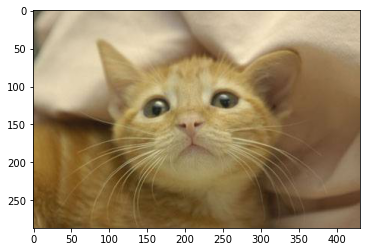

In [10]:
# 1) Pillow image
from PIL import Image
img = Image.open(fname)
plt.imshow(img);

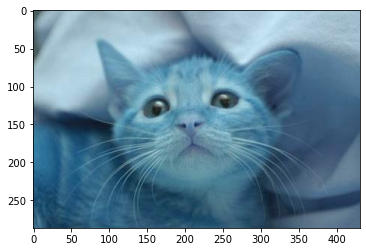

In [17]:
# 2) OpenCV image, 순서가 RGB가 아니고, BGR로 읽음
import cv2
img2 = cv2.imread(fname)
plt.imshow(img2);

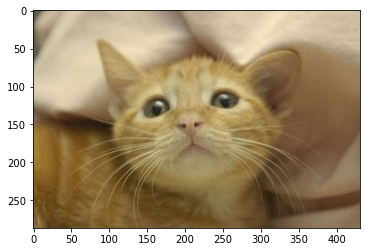

In [18]:
# cv2 RGB순서로 읽는방법
img3 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img3);

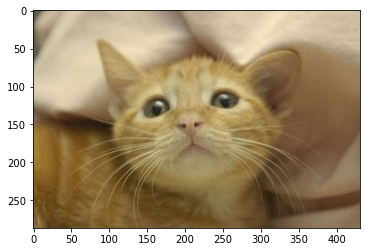

In [19]:
# OpenCV의 데이터는 numpy array
img2 = img2[:,:,::-1]
plt.imshow(img2);

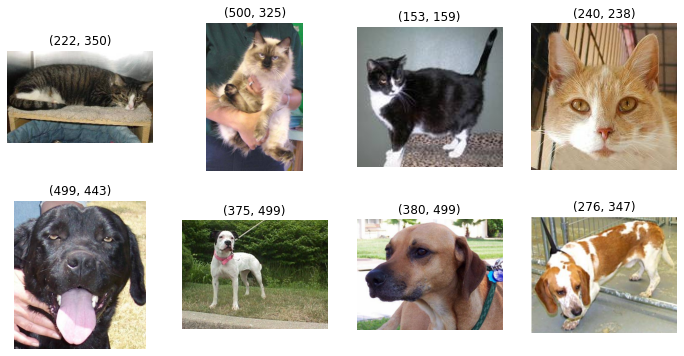

In [20]:
plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    cat = cv2.imread(os.path.join(train_cats_dir, train_cats_fnames[i]))[:,:,::-1]
    plt.imshow(cat), plt.axis('off'), plt.title(cat.shape[:-1])

    plt.subplot(2, 4, i+5)
    dog = cv2.imread(os.path.join(train_dogs_dir, train_dogs_fnames[i]))[:,:,::-1]
    plt.imshow(dog), plt.axis('off'), plt.title(dog.shape[:-1])
plt.show()

- 모델 구성

In [21]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [22]:
model = Sequential([
    Conv2D(16, (3,3), input_shape=(150,150,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [23]:
from tensorflow.keras.optimizers import RMSprop
model.compile(
    optimizer=RMSprop(learning_rate=0.001, decay=1e-8),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [24]:
model_path = 'best-cats-and-dogs-v1.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10)

- 파일에서 이미지 데이터 읽어서 학습시키는 방법

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [27]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)
test_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


- 모델 실행

In [ ]:
hist = model.fit(
    train_generator, 
    validation_data = test_generator,
    epochs=100, 
    steps_per_epoch=100, 
    validation_steps = 50,
    callbacks = [mc,es]
    )

- 테스트 이미지 분류

In [ ]:
from google.colab import files

up = files.upload()

In [ ]:
img = cv2.imread('고양이.jpg')[:,:,::-1]
plt.imshow(img), plt.title(img.shape[:-1]);

In [ ]:
# 150 x 150 size
img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
plt.imshow(img);

In [ ]:
best_model.predict(img.reshape(1,150,150,3))

In [ ]:
for fname in up.keys():     # 하나씩 나옴
    img = cv2.imread(fname)[:,:,::-1]
    if sum(img.shape[:-1]) > 300:
        img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)        # 큰걸 작게
    else:
        img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_CUBIC)       # 작은걸 크게
    classes = best_model.predict(img.reshape(1,150,150,3))
    print(f"{classes[0,0]:.4f} {fname} is a {'dog' if classes[0,0] > 0.5 else 'cat'}")